# Heart Disease Prediction

Dataset: Using CDC's 2022 annual survey data of 400k+ adults related to their health status, that has been curated by Kamil Pytlak on Kaggle. https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease/data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer, MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler

from google.colab import drive

In [98]:
url = 'heart_2022_with_nans.csv'
df_raw = pd.read_csv(url)

# drive.mount('/content/drive')
# df_raw = pd.read_csv('/content/drive/My Drive/Machine Learning/ALP/heart_2022_with_nans.csv')

df_raw.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,Alabama,Female,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,8.0,NaN,No,...,NaN,NaN,NaN,No,No,Yes,No,"Yes, received tetanus shot but not sure what type",No,No
1,Alabama,Female,Excellent,0.0,0.0,NaN,No,6.0,NaN,No,...,1.60,68.04,26.57,No,No,No,No,"No, did not receive any tetanus shot in the pa...",No,No
2,Alabama,Female,Very good,2.0,3.0,Within past year (anytime less than 12 months ...,Yes,5.0,NaN,No,...,1.57,63.50,25.61,No,No,No,No,NaN,No,Yes
3,Alabama,Female,Excellent,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,7.0,NaN,No,...,1.65,63.50,23.30,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,No
4,Alabama,Female,Fair,2.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,NaN,No,...,1.57,53.98,21.77,Yes,No,No,Yes,"No, did not receive any tetanus shot in the pa...",No,No


# Preprocessing

Checking the missing value in the dataset

In [3]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445132 entries, 0 to 445131
Data columns (total 40 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   State                      445132 non-null  object 
 1   Sex                        445132 non-null  object 
 2   GeneralHealth              443934 non-null  object 
 3   PhysicalHealthDays         434205 non-null  float64
 4   MentalHealthDays           436065 non-null  float64
 5   LastCheckupTime            436824 non-null  object 
 6   PhysicalActivities         444039 non-null  object 
 7   SleepHours                 439679 non-null  float64
 8   RemovedTeeth               433772 non-null  object 
 9   HadHeartAttack             442067 non-null  object 
 10  HadAngina                  440727 non-null  object 
 11  HadStroke                  443575 non-null  object 
 12  HadAsthma                  443359 non-null  object 
 13  HadSkinCancer              44

## 1. Handle Missing Value and Outliers in numerical column

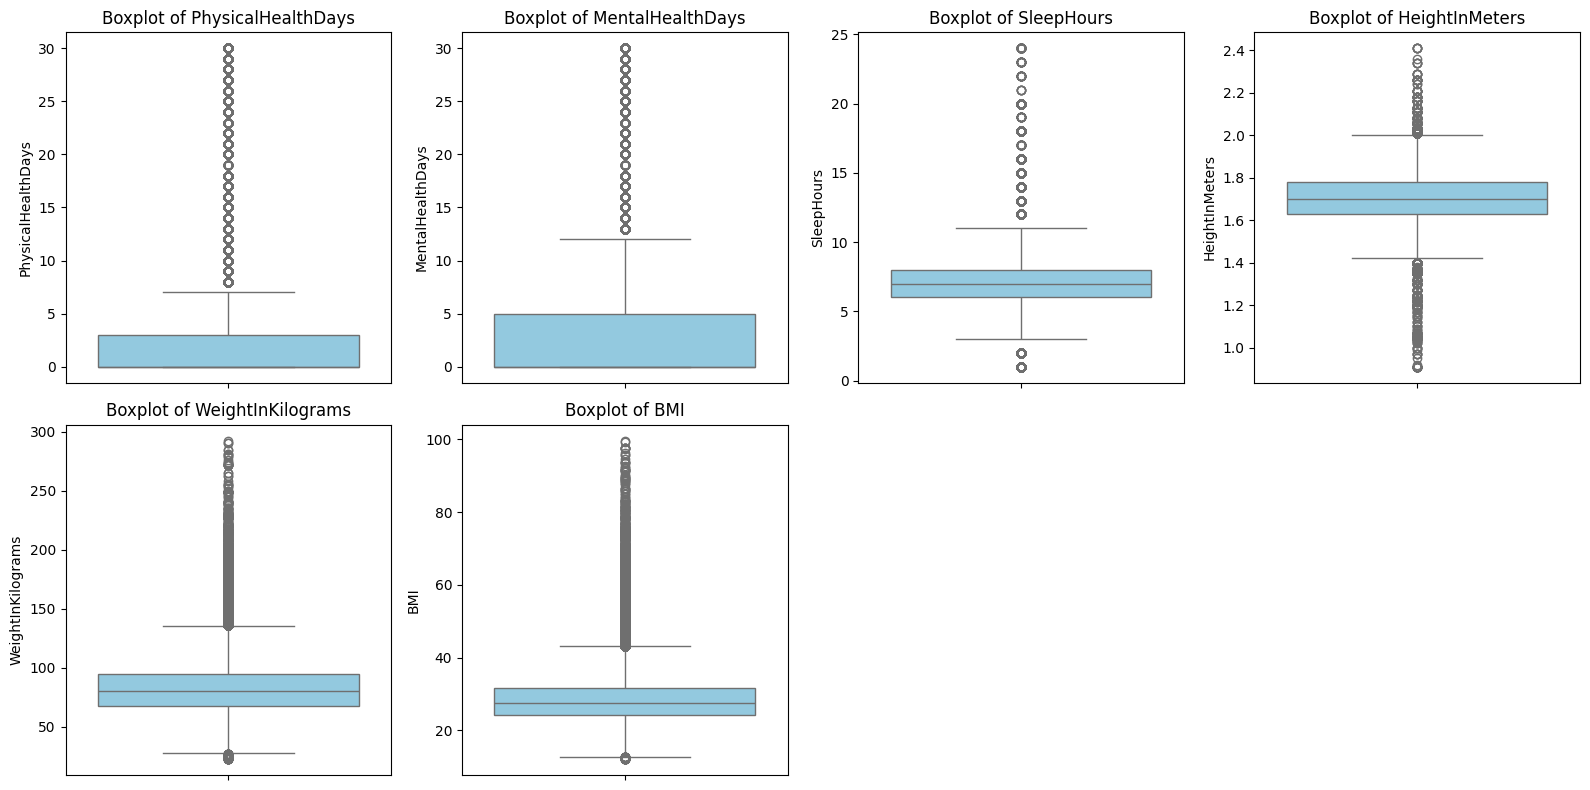

In [4]:
# Select only numerical columns
numeric_features = df_raw.select_dtypes(include=['number']).columns

# Define the number of columns per row for the plots
n_cols = 4  # Number of columns in each row
n_rows = -(-len(numeric_features) // n_cols)  # Calculate number of rows needed

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
axes = axes.flatten()  # Flatten the axes array for easier indexing

# Loop through each numerical column and create a boxplot
for i, col in enumerate(numeric_features):
    sns.boxplot(y=df_raw[col], ax=axes[i], color='skyblue')
    axes[i].set_title(f'Boxplot of {col}')
    axes[i].set_ylabel(col)

# Remove any empty subplots if the grid has extra spaces
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


- Using median to insert value in the missing data for PhysicalHealthDay, MentalHealthDay, SleepHours, WeightInKilograms, and BMI because the data distribution is skewed.
- Using mean to insert value in the missing data for HeightInKilograms because the data distribution is normal (not skewed).

In [5]:
# Handle missing values for numerical columns based on their data distribution
df_raw['PhysicalHealthDays'] = df_raw['PhysicalHealthDays'].fillna(df_raw['PhysicalHealthDays'].median())
df_raw['MentalHealthDays'] = df_raw['MentalHealthDays'].fillna(df_raw['MentalHealthDays'].median())
df_raw['SleepHours'] = df_raw['SleepHours'].fillna(df_raw['SleepHours'].median())
df_raw['WeightInKilograms'] = df_raw['WeightInKilograms'].fillna(df_raw['WeightInKilograms'].median())
df_raw['BMI'] = df_raw['BMI'].fillna(df_raw['BMI'].median())

df_raw['HeightInMeters'] = df_raw['HeightInMeters'].fillna(df_raw['HeightInMeters'].mean())

Use describe to see data distribution in numerical column

In [6]:
df_raw.describe()

,PhysicalHealthDays,MentalHealthDays,SleepHours,HeightInMeters,WeightInKilograms,BMI
count,445132.000000,445132.000000,445132.000000,445132.000000,445132.000000,445132.000000
mean,4.241187,4.293378,7.022701,1.702691,82.853795,28.410347
std,8.607936,8.324664,1.493196,0.103671,20.420694,6.194472
min,0.000000,0.000000,1.000000,0.910000,22.680000,12.020000
25%,0.000000,0.000000,6.000000,1.630000,68.490000,24.410000
50%,0.000000,0.000000,7.000000,1.700000,80.740000,27.440000
75%,3.000000,4.000000,8.000000,1.780000,91.630000,31.010000
max,30.000000,30.000000,24.000000,2.410000,292.570000,99.640000


Because we are in a healthcare dataset, we value the outliers data cause it can mean something. We only handle anomaly outliers like in SleepHours column we found a max of 24hrs of sleep which is almost impossible.

In [7]:
df_raw['SleepHours'] = df_raw['SleepHours'].apply(lambda x: 9 if x > 9 else x)

## 2. Handle Missing Value (Categorical Column)

Viewing the distribution of data

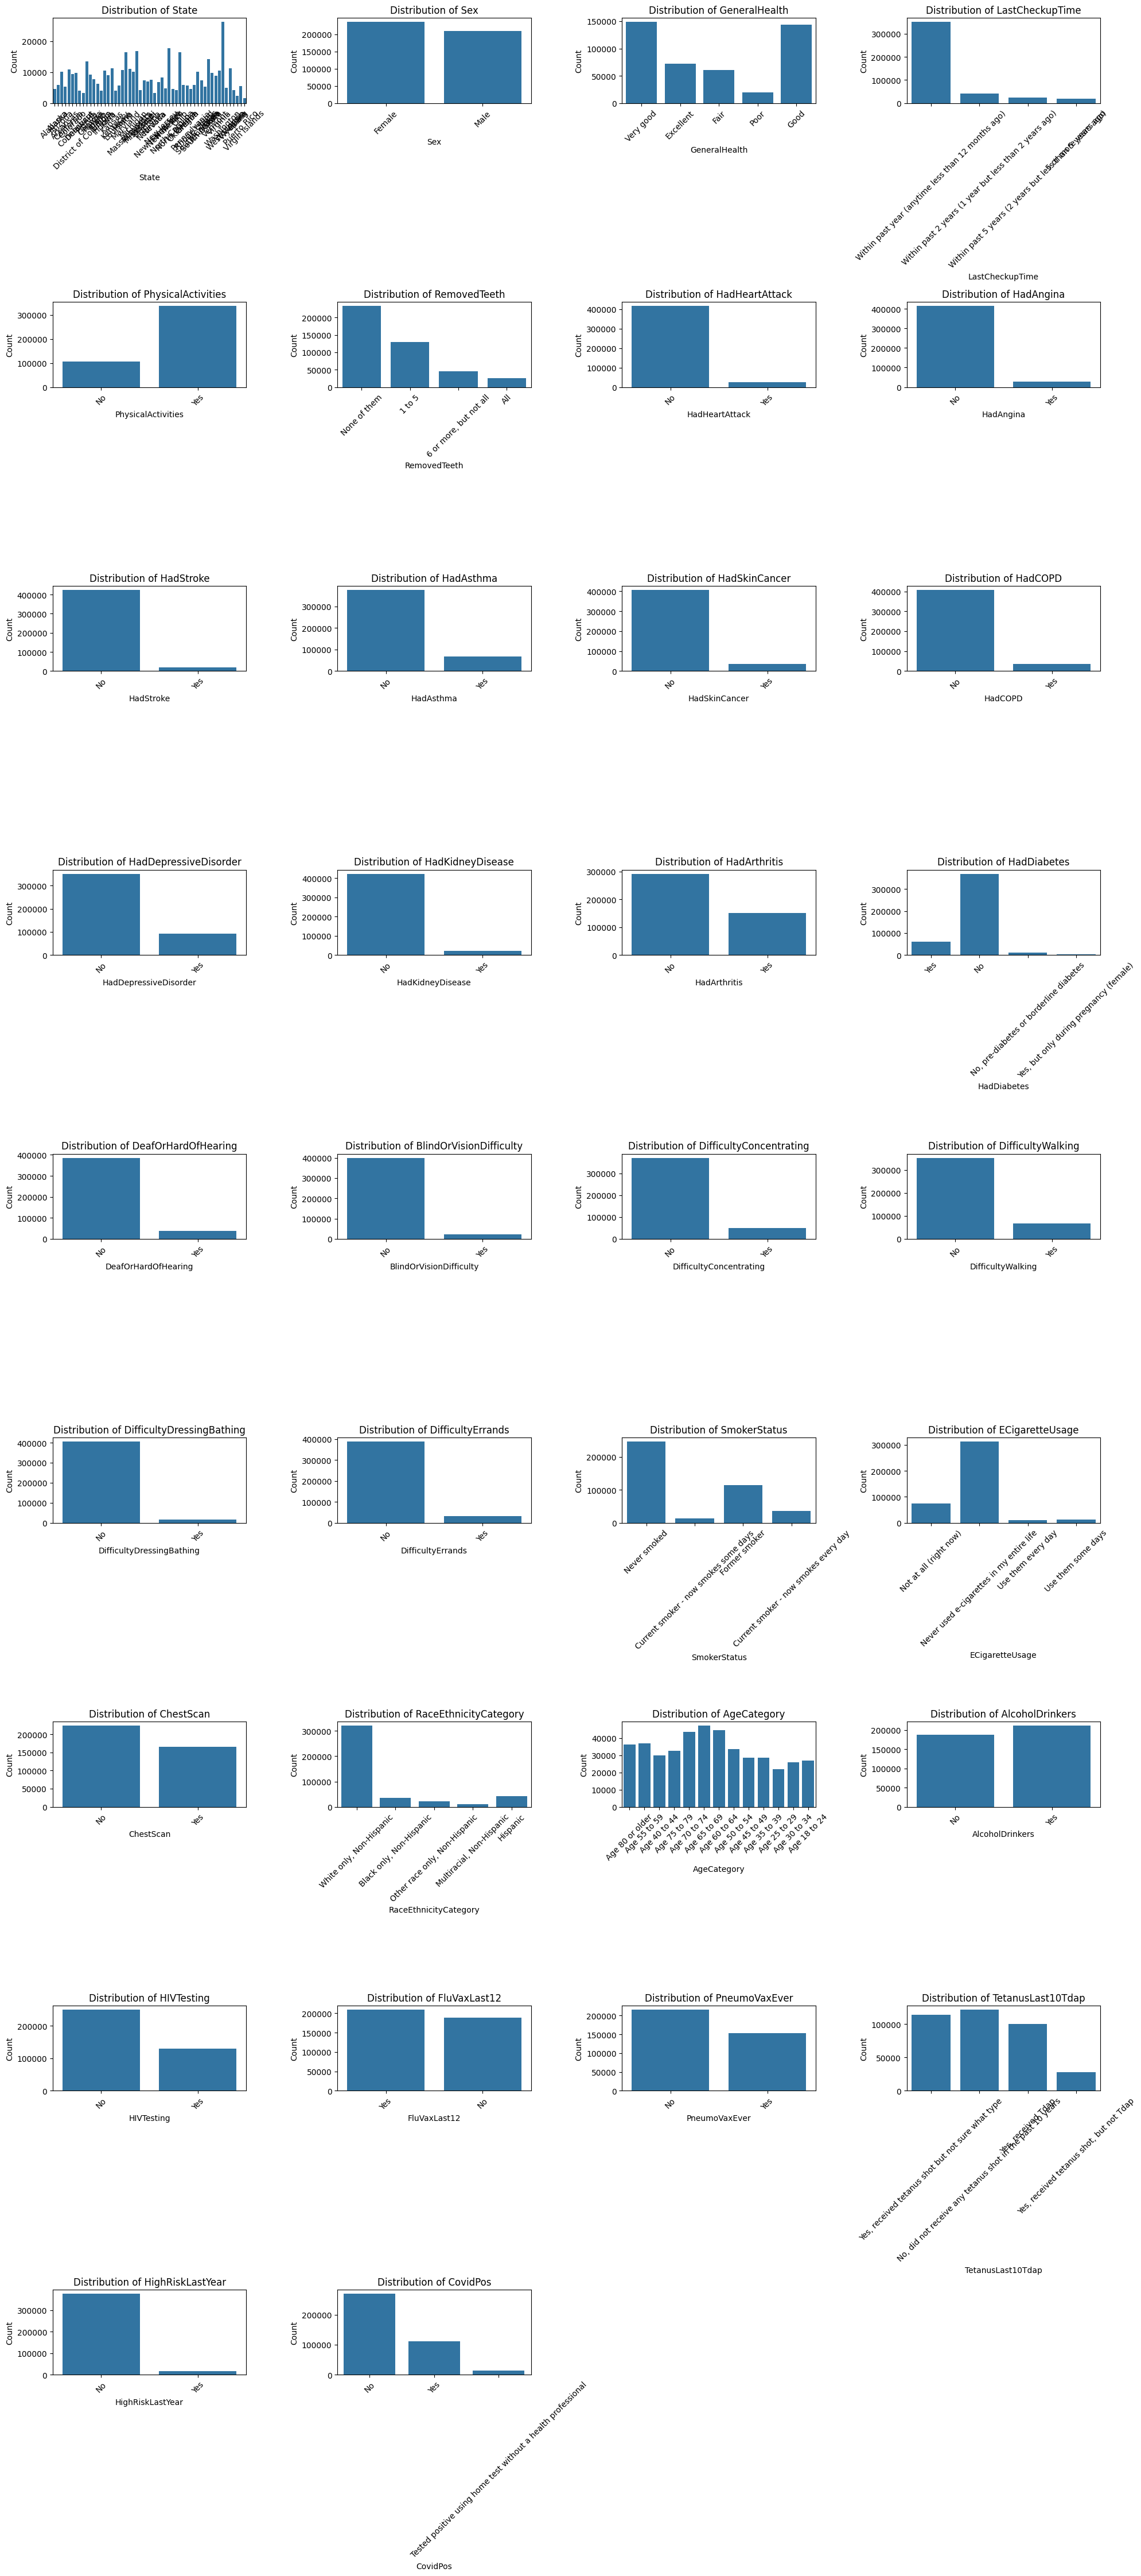

In [101]:
categorical_columns = df_raw.select_dtypes(exclude=['number']).columns

# Number of columns for the subplot grid
n_cols = 4
n_rows = -(-len(categorical_columns) // n_cols)

# Set up the subplot grid
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
axes = axes.flatten()

# Plot the distribution for each categorical column
for i, col in enumerate(categorical_columns):
    sns.countplot(data=df_raw, x=col, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")
    axes[i].tick_params(axis='x', rotation=45)

# Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Checking the uniques values in each cateforical column

In [8]:
# Filter out numerical columns
categorical_columns = df_raw.select_dtypes(exclude=['number']).columns

# Iterate over each categorical column and print unique values
for column in categorical_columns:
    unique_values = df_raw[column].unique()
    print(f"Column: {column}")
    print(f"Number of Unique Values: {len(unique_values)}")
    print(f"Sample Values: {unique_values}")  # Show only the first 10 unique values
    print("-" * 50)

Column: State
Number of Unique Values: 54
Sample Values: ['Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California' 'Colorado'
 'Connecticut' 'Delaware' 'District of Columbia' 'Florida' 'Georgia'
 'Hawaii' 'Idaho' 'Illinois' 'Indiana' 'Iowa' 'Kansas' 'Kentucky'
 'Louisiana' 'Maine' 'Maryland' 'Massachusetts' 'Michigan' 'Minnesota'
 'Mississippi' 'Missouri' 'Montana' 'Nebraska' 'Nevada' 'New Hampshire'
 'New Jersey' 'New Mexico' 'New York' 'North Carolina' 'North Dakota'
 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania' 'Rhode Island' 'South Carolina'
 'South Dakota' 'Tennessee' 'Texas' 'Utah' 'Vermont' 'Virginia'
 'Washington' 'West Virginia' 'Wisconsin' 'Wyoming' 'Guam' 'Puerto Rico'
 'Virgin Islands']
--------------------------------------------------
Column: Sex
Number of Unique Values: 2
Sample Values: ['Female' 'Male']
--------------------------------------------------
Column: GeneralHealth
Number of Unique Values: 6
Sample Values: ['Very good' 'Excellent' 'Fair' 'Poor' 'Good' nan]
----------

Checking how many missing value in each categorical column

In [9]:
# Select categorical columns
categorical_columns = df_raw.select_dtypes(include=['object']).columns

# Calculate the percentage of missing data for each categorical column
missing_percentages = df_raw[categorical_columns].isnull().mean() * 100

# Print the results
for col, percentage in missing_percentages.items():
    print(f"Column: {col}, Missing Data: {percentage:.2f}%")

Column: State, Missing Data: 0.00%
Column: Sex, Missing Data: 0.00%
Column: GeneralHealth, Missing Data: 0.27%
Column: LastCheckupTime, Missing Data: 1.87%
Column: PhysicalActivities, Missing Data: 0.25%
Column: RemovedTeeth, Missing Data: 2.55%
Column: HadHeartAttack, Missing Data: 0.69%
Column: HadAngina, Missing Data: 0.99%
Column: HadStroke, Missing Data: 0.35%
Column: HadAsthma, Missing Data: 0.40%
Column: HadSkinCancer, Missing Data: 0.71%
Column: HadCOPD, Missing Data: 0.50%
Column: HadDepressiveDisorder, Missing Data: 0.63%
Column: HadKidneyDisease, Missing Data: 0.43%
Column: HadArthritis, Missing Data: 0.59%
Column: HadDiabetes, Missing Data: 0.24%
Column: DeafOrHardOfHearing, Missing Data: 4.64%
Column: BlindOrVisionDifficulty, Missing Data: 4.84%
Column: DifficultyConcentrating, Missing Data: 5.45%
Column: DifficultyWalking, Missing Data: 5.39%
Column: DifficultyDressingBathing, Missing Data: 5.37%
Column: DifficultyErrands, Missing Data: 5.76%
Column: SmokerStatus, Missing

- For low missing value, we just impute them with mode to preserve original data distribution and it wont bias the dataset significantly
- For medium missing value, we impute them with reasonable default value instead of mode because it might bias the dataset.
- For high missing value, we use new unique value such as 'unknown' to prevent any bias in the dataset

In [10]:
data_preprocessed = df_raw

# Handle missing df_raw for low missingness columns (<5%) with mode
low_missing_columns = [
    'GeneralHealth', 'PhysicalActivities', 'RemovedTeeth', 'LastCheckupTime',
    'HadHeartAttack', 'HadAngina', 'HadStroke', 'HadAsthma', 'HadSkinCancer',
    'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis',
    'HadDiabetes', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty', 'RaceEthnicityCategory', 'AgeCategory'
]

for col in low_missing_columns:
    data_preprocessed[col] = data_preprocessed[col].fillna(data_preprocessed[col].mode()[0])

# Handle missing data for moderate missingness columns (5%-10%)
moderate_missing_values = {
    'DifficultyConcentrating': 'No',
    'DifficultyWalking': 'No',
    'DifficultyDressingBathing': 'No',
    'DifficultyErrands': 'No',
    'SmokerStatus': 'Never smoked',
    'ECigaretteUsage': 'Not at all (right now)'
}

for col, fill_value in moderate_missing_values.items():
    data_preprocessed[col] = data_preprocessed[col].fillna(fill_value)

# Handle missing data for high missingness columns (10%-20%) with "Unknown"
high_missing_values = {
    'ChestScan': 'No Scan',
    'AlcoholDrinkers': 'Unknown',
    'HighRiskLastYear': 'Unknown',
    'CovidPos': 'Unknown',
    'HIVTesting': 'Unknown',
    'FluVaxLast12': 'Unknown',
    'PneumoVaxEver': 'Unknown',
    'TetanusLast10Tdap': 'Unknown',
}

for col, fill_value in high_missing_values.items():
    data_preprocessed[col] = data_preprocessed[col].fillna(fill_value)

Check again the data with info and describe to make sure all secured

In [11]:
data_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445132 entries, 0 to 445131
Data columns (total 40 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   State                      445132 non-null  object 
 1   Sex                        445132 non-null  object 
 2   GeneralHealth              445132 non-null  object 
 3   PhysicalHealthDays         445132 non-null  float64
 4   MentalHealthDays           445132 non-null  float64
 5   LastCheckupTime            445132 non-null  object 
 6   PhysicalActivities         445132 non-null  object 
 7   SleepHours                 445132 non-null  float64
 8   RemovedTeeth               445132 non-null  object 
 9   HadHeartAttack             445132 non-null  object 
 10  HadAngina                  445132 non-null  object 
 11  HadStroke                  445132 non-null  object 
 12  HadAsthma                  445132 non-null  object 
 13  HadSkinCancer              44

In [12]:
data_preprocessed.describe()

,PhysicalHealthDays,MentalHealthDays,SleepHours,HeightInMeters,WeightInKilograms,BMI
count,445132.000000,445132.000000,445132.000000,445132.000000,445132.000000,445132.000000
mean,4.241187,4.293378,6.950877,1.702691,82.853795,28.410347
std,8.607936,8.324664,1.282987,0.103671,20.420694,6.194472
min,0.000000,0.000000,1.000000,0.910000,22.680000,12.020000
25%,0.000000,0.000000,6.000000,1.630000,68.490000,24.410000
50%,0.000000,0.000000,7.000000,1.700000,80.740000,27.440000
75%,3.000000,4.000000,8.000000,1.780000,91.630000,31.010000
max,30.000000,30.000000,9.000000,2.410000,292.570000,99.640000


# Label Encoding

Use label encoding for the encoder because most of the datas are binary and ordinal

In [13]:
# Create a dictionary to store label encodings for each column
label_encodings = {}

# List of categorical columns to encode
categorical_columns = data_preprocessed.select_dtypes(include=['object']).columns

# Apply label encoding to each categorical column
for col in categorical_columns:
    le = LabelEncoder()
    # Fit and transform the column
    data_preprocessed[col] = le.fit_transform(data_preprocessed[col].astype(str))
    # Store the mapping of labels for reference
    label_encodings[col] = dict(zip(le.classes_, le.transform(le.classes_)))

# Display the encoding mappings
for col, mapping in label_encodings.items():
    print(f"Column: {col}")
    for category, label in mapping.items():
        print(f"  {category} -> {label}")
    print("-" * 50)


Column: State
  Alabama -> 0
  Alaska -> 1
  Arizona -> 2
  Arkansas -> 3
  California -> 4
  Colorado -> 5
  Connecticut -> 6
  Delaware -> 7
  District of Columbia -> 8
  Florida -> 9
  Georgia -> 10
  Guam -> 11
  Hawaii -> 12
  Idaho -> 13
  Illinois -> 14
  Indiana -> 15
  Iowa -> 16
  Kansas -> 17
  Kentucky -> 18
  Louisiana -> 19
  Maine -> 20
  Maryland -> 21
  Massachusetts -> 22
  Michigan -> 23
  Minnesota -> 24
  Mississippi -> 25
  Missouri -> 26
  Montana -> 27
  Nebraska -> 28
  Nevada -> 29
  New Hampshire -> 30
  New Jersey -> 31
  New Mexico -> 32
  New York -> 33
  North Carolina -> 34
  North Dakota -> 35
  Ohio -> 36
  Oklahoma -> 37
  Oregon -> 38
  Pennsylvania -> 39
  Puerto Rico -> 40
  Rhode Island -> 41
  South Carolina -> 42
  South Dakota -> 43
  Tennessee -> 44
  Texas -> 45
  Utah -> 46
  Vermont -> 47
  Virgin Islands -> 48
  Virginia -> 49
  Washington -> 50
  West Virginia -> 51
  Wisconsin -> 52
  Wyoming -> 53
---------------------------------------

# Feature Selection

Our current data has been refined from the original datasets, reducing hundreds of features to 40, focusing on those most relevant to cardiovascular health.

After some research, we have decided to remove several features isn't as relevant to cardiovascular as the others.

In [102]:
columns_to_drop = ['State', 'HadSkinCancer', 'HIVTesting', 'FluVaxLast12', 'TetanusLast10Tdap']

data_preprocessed = data_preprocessed.drop(columns=columns_to_drop)

In [103]:
dataset_heart_attack = data_preprocessed.copy()
dataset_angina = data_preprocessed.copy()
dataset_stroke = data_preprocessed.copy()

## Heart Attack

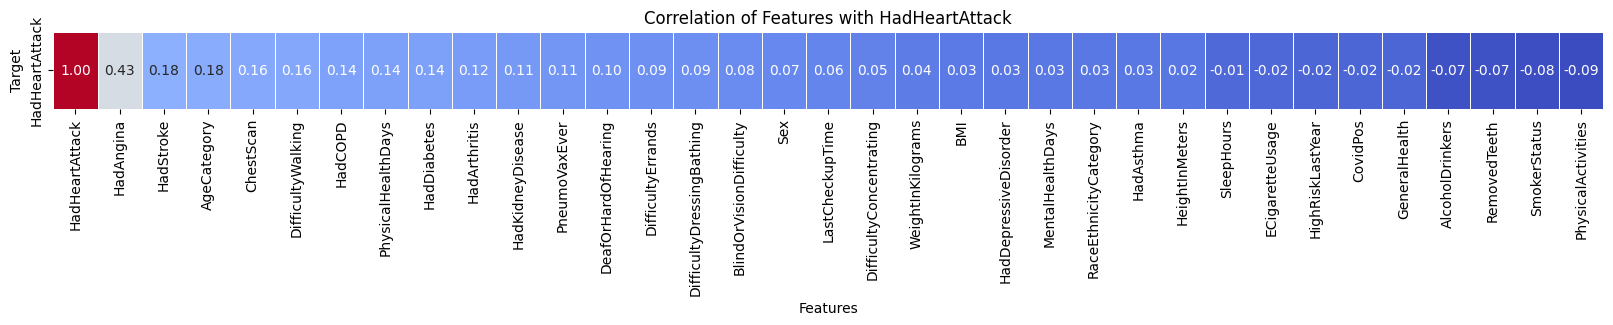

In [104]:
# Calculate correlation matrix
correlation_matrix = dataset_heart_attack.corr()

# Extract correlations with the target variable 'HadHeartAttack'
target_correlation = correlation_matrix[['HadHeartAttack']].sort_values(by='HadHeartAttack', ascending=False)

# Plot horizontal heatmap
plt.figure(figsize=(20, 1))
sns.heatmap(target_correlation.T, annot=True, fmt=".2f", cmap='coolwarm', cbar=False, linewidths=0.5)
plt.title('Correlation of Features with HadHeartAttack')
plt.xlabel('Features')
plt.ylabel('Target')
plt.show()

Features more than 0.09 / less than -0.09:

In [133]:
heart_attack_heatmap = [
    'HadAngina', 'AgeCategory', 'ChestScan', 'DifficultyWalking', 'HadCOPD', 'PhysicalHealthDays', 'HadDiabetes',
    'HadArthritis', 'HadKidneyDisease', 'PneumoVaxEver', 'DeafOrHardOfHearing', 'HadStroke'
]

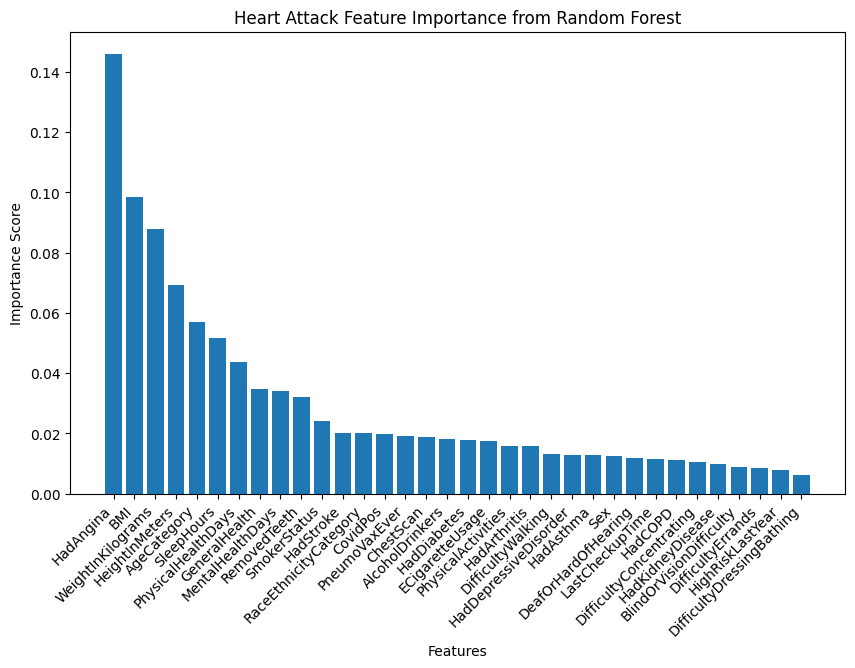

In [106]:
X = dataset_heart_attack.drop(columns=['HadHeartAttack'])
y = dataset_heart_attack['HadHeartAttack']

rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(feature_importance['Feature'], feature_importance['Importance'])
plt.xticks(rotation=45, ha='right')
plt.title('Heart Attack Feature Importance from Random Forest')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.show()

Features with importance score of more than 0.02

In [107]:
heart_attack_rf = [
    'HadAngina', 'BMI', 'WeightInKilograms', 'HeightInMeters', 'AgeCategory', 'SleepHours', 'PhysicalHealthDays', 'GeneralHealth', 'MentalHealthDays',
    'RemovedTeeth', 'SmokerStatus'
]

In [134]:
heart_attack_features = sorted(list(set(heart_attack_heatmap).union(set(heart_attack_rf))) + ['HadHeartAttack'])

dataset_final_heart_attack = dataset_heart_attack[heart_attack_features]

dataset_final_heart_attack.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445132 entries, 0 to 445131
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   AgeCategory          445132 non-null  int64  
 1   BMI                  445132 non-null  float64
 2   ChestScan            445132 non-null  int64  
 3   DeafOrHardOfHearing  445132 non-null  int64  
 4   DifficultyWalking    445132 non-null  int64  
 5   GeneralHealth        445132 non-null  int64  
 6   HadAngina            445132 non-null  int64  
 7   HadArthritis         445132 non-null  int64  
 8   HadCOPD              445132 non-null  int64  
 9   HadDiabetes          445132 non-null  int64  
 10  HadHeartAttack       445132 non-null  int64  
 11  HadKidneyDisease     445132 non-null  int64  
 12  HadStroke            445132 non-null  int64  
 13  HeightInMeters       445132 non-null  float64
 14  MentalHealthDays     445132 non-null  float64
 15  PhysicalHealthDay

## Angina

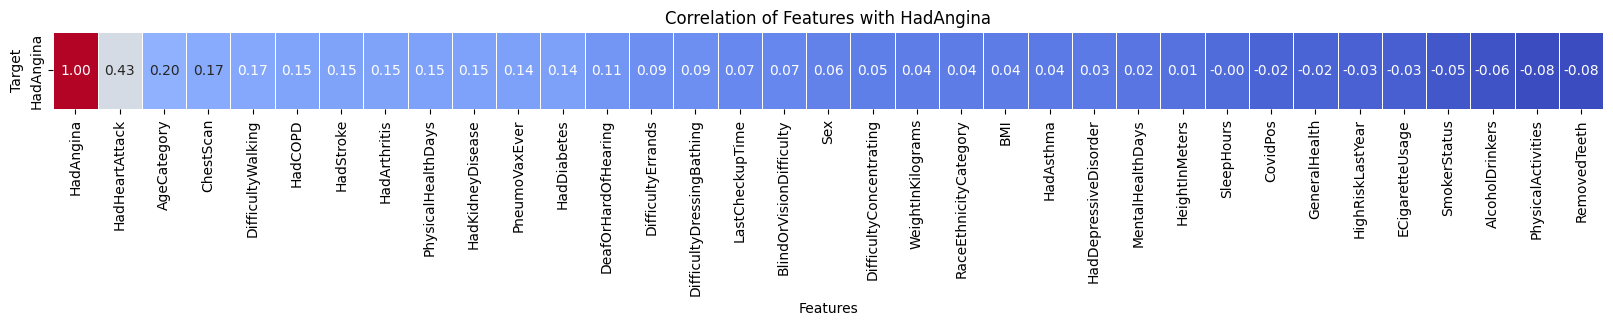

In [110]:
# Calculate correlation matrix
correlation_matrix = dataset_angina.corr()

# Extract correlations with the target variable 'HadAngina'
target_correlation = correlation_matrix[['HadAngina']].sort_values(by='HadAngina', ascending=False)

# Plot horizontal heatmap
plt.figure(figsize=(20, 1))
sns.heatmap(target_correlation.T, annot=True, fmt=".2f", cmap='coolwarm', cbar=False, linewidths=0.5)
plt.title('Correlation of Features with HadAngina')
plt.xlabel('Features')
plt.ylabel('Target')
plt.show()

Features more than 0.09 / less than -0.09:

In [111]:
angina_heatmap = [
    'AgeCategory', 'ChestScan', 'DifficultyWalking', 'HadCOPD', 'HadArthritis', 'PhysicalHealthDays', 'HadKidneyDisease', 'PneumoVaxEver',
    'HadDiabetes', 'DeafOrHardOfHearing'
]

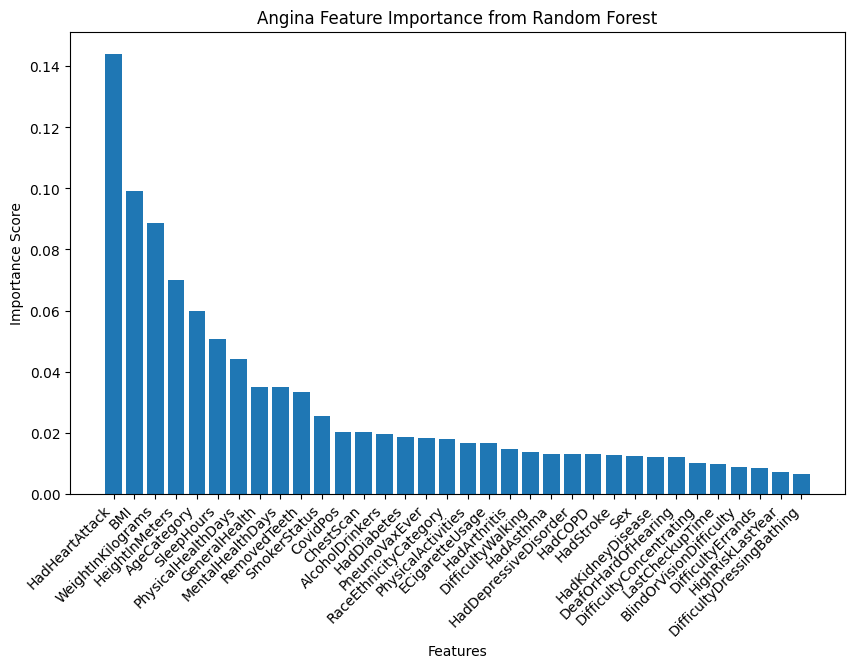

In [112]:
X = dataset_angina.drop(columns=['HadAngina'])
y = dataset_angina['HadAngina']

rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(feature_importance['Feature'], feature_importance['Importance'])
plt.xticks(rotation=45, ha='right')
plt.title('Angina Feature Importance from Random Forest')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.show()

Features with importance score of more than 0.02:

In [113]:
angina_rf = [
    'BMI', 'WeightInKilograms', 'HeightInMeters', 'AgeCategory', 'SleepHours', 'PhysicalHealthDays', 'GeneralHealth', 'MentalHealthDays',
    'RemovedTeeth', 'SmokerStatus'
]

In [115]:
angina_features = sorted(list(set(angina_heatmap).union(set(angina_rf))) + ['HadAngina'])

dataset_final_angina = dataset_angina[angina_features]

dataset_final_angina.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445132 entries, 0 to 445131
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   AgeCategory          445132 non-null  int64  
 1   BMI                  445132 non-null  float64
 2   ChestScan            445132 non-null  int64  
 3   DeafOrHardOfHearing  445132 non-null  int64  
 4   DifficultyWalking    445132 non-null  int64  
 5   GeneralHealth        445132 non-null  int64  
 6   HadAngina            445132 non-null  int64  
 7   HadArthritis         445132 non-null  int64  
 8   HadCOPD              445132 non-null  int64  
 9   HadDiabetes          445132 non-null  int64  
 10  HadKidneyDisease     445132 non-null  int64  
 11  HeightInMeters       445132 non-null  float64
 12  MentalHealthDays     445132 non-null  float64
 13  PhysicalHealthDays   445132 non-null  float64
 14  PneumoVaxEver        445132 non-null  int64  
 15  RemovedTeeth     

## Stroke

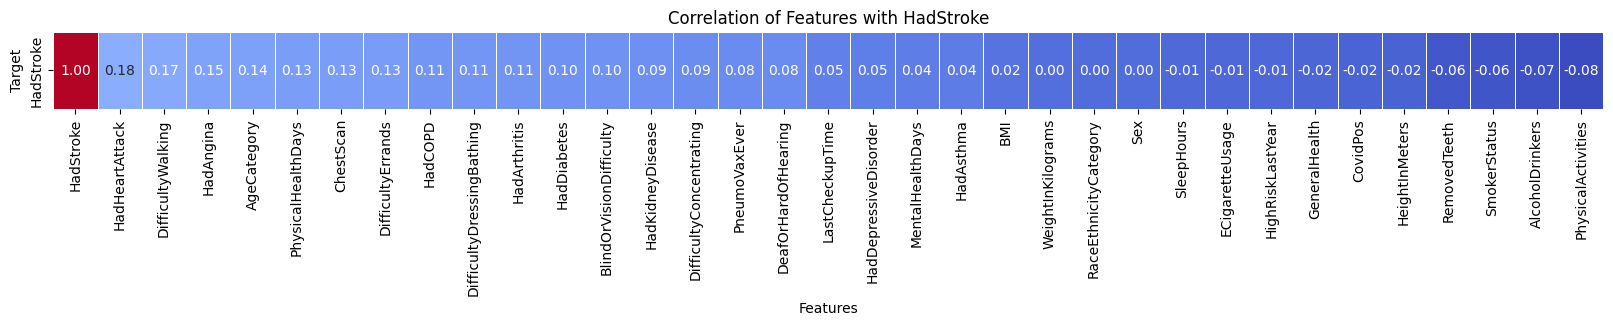

In [116]:
# Calculate correlation matrix
correlation_matrix = dataset_stroke.corr()

# Extract correlations with the target variable 'HadStroke'
target_correlation = correlation_matrix[['HadStroke']].sort_values(by='HadStroke', ascending=False)

# Plot horizontal heatmap
plt.figure(figsize=(20, 1))
sns.heatmap(target_correlation.T, annot=True, fmt=".2f", cmap='coolwarm', cbar=False, linewidths=0.5)
plt.title('Correlation of Features with HadStroke')
plt.xlabel('Features')
plt.ylabel('Target')
plt.show()

Features more than 0.09 / less than -0.09:

In [135]:
stroke_heatmap = [
    'DifficultyWalking', 'HadAngina', 'AgeCategory', 'PhysicalHealthDays', 'ChestScan', 'DifficultyErrands', 'HadCOPD',
    'DifficultyDressingBathing', 'HadArthritis', 'HadDiabetes', 'BlindOrVisionDifficulty'
]

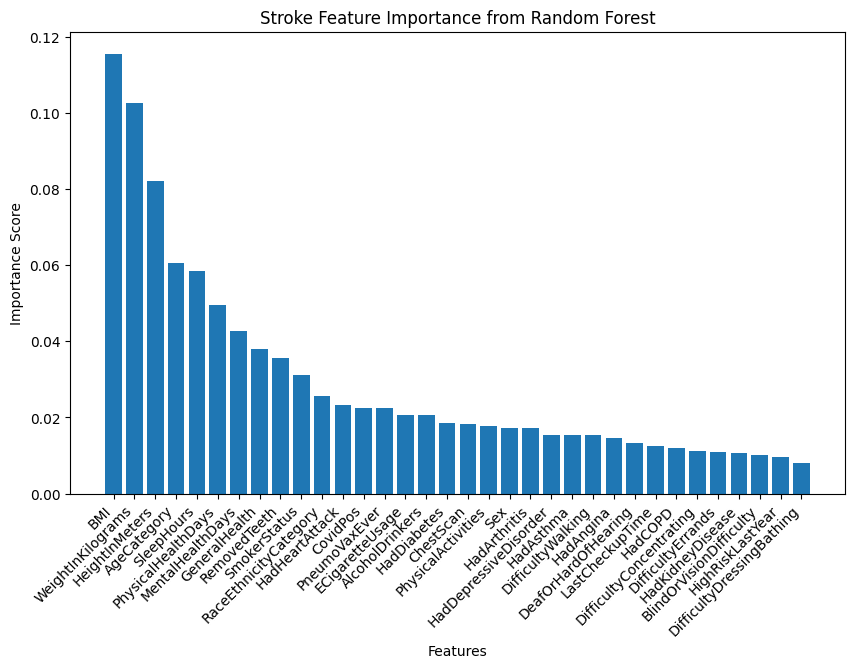

In [118]:
X = dataset_stroke.drop(columns=['HadStroke'])
y = dataset_stroke['HadStroke']

rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(feature_importance['Feature'], feature_importance['Importance'])
plt.xticks(rotation=45, ha='right')
plt.title('Stroke Feature Importance from Random Forest')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.show()

Features with importance score of more than 0.02:

In [119]:
stroke_rf = [
    'BMI', 'WeightInKilograms', 'HeightInMeters', 'AgeCategory', 'SleepHours', 'PhysicalHealthDays', 'MentalHealthDays', 'GeneralHealth',
    'RemovedTeeth', 'SmokerStatus'
]

In [136]:
stroke_features = sorted(list(set(stroke_heatmap).union(set(stroke_rf))) + ['HadStroke'])

dataset_final_stroke = dataset_stroke[stroke_features]

dataset_final_stroke.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445132 entries, 0 to 445131
Data columns (total 20 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   AgeCategory                445132 non-null  int64  
 1   BMI                        445132 non-null  float64
 2   BlindOrVisionDifficulty    445132 non-null  int64  
 3   ChestScan                  445132 non-null  int64  
 4   DifficultyDressingBathing  445132 non-null  int64  
 5   DifficultyErrands          445132 non-null  int64  
 6   DifficultyWalking          445132 non-null  int64  
 7   GeneralHealth              445132 non-null  int64  
 8   HadAngina                  445132 non-null  int64  
 9   HadArthritis               445132 non-null  int64  
 10  HadCOPD                    445132 non-null  int64  
 11  HadDiabetes                445132 non-null  int64  
 12  HadStroke                  445132 non-null  int64  
 13  HeightInMeters             44

## Conclusion

To improve our predictions, we decided to use the predicted results of one target variable as a feature in the next model.
*   First, we will predict HadAngina
*   Second, we will predict HadStroke
*   Lastly, we will predict HadHeartAttack

In [137]:
features_stroke = set(dataset_final_stroke.columns)
features_heart_attack = set(dataset_final_heart_attack.columns)
features_angina = set(dataset_final_angina.columns)

# Combine all features into a single set to remove duplicates
all_features = features_stroke.union(features_heart_attack).union(features_angina)

# Convert to a sorted list for better readability
all_features_sorted = sorted(all_features)

# Display the consolidated features
print("All Unique Features Across Datasets:")
for feature in all_features_sorted:
    print(feature)

All Unique Features Across Datasets:
AgeCategory
BMI
BlindOrVisionDifficulty
ChestScan
DeafOrHardOfHearing
DifficultyDressingBathing
DifficultyErrands
DifficultyWalking
GeneralHealth
HadAngina
HadArthritis
HadCOPD
HadDiabetes
HadHeartAttack
HadKidneyDisease
HadStroke
HeightInMeters
MentalHealthDays
PhysicalHealthDays
PneumoVaxEver
RemovedTeeth
SleepHours
SmokerStatus
WeightInKilograms


# Undersampling

Viewing the distribution data of 'HadHeartAttack', 'HadAngina', and 'HadStroke'

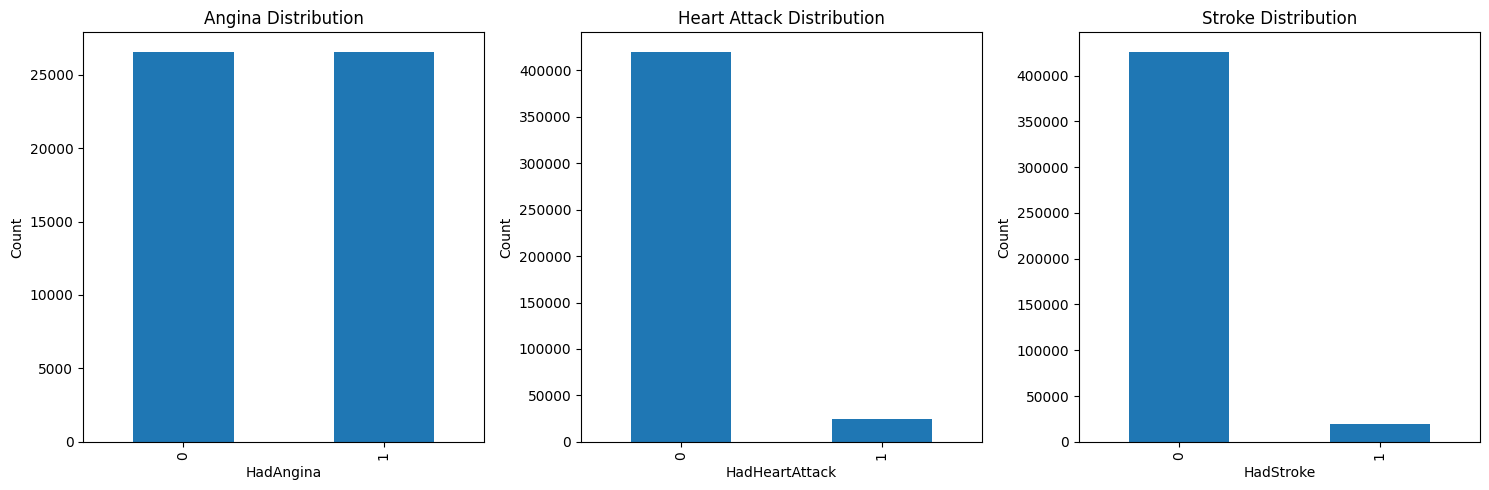

In [138]:
# Define the datasets and their respective target columns
datasets = {
    'Angina': (dataset_final_angina, 'HadAngina'),
    'Heart Attack': (dataset_final_heart_attack, 'HadHeartAttack'),
    'Stroke': (dataset_final_stroke, 'HadStroke')
}

# Create subplots for comparison
fig, axes = plt.subplots(1, len(datasets), figsize=(15, 5))

# Loop through datasets and plot on respective axes
for ax, (name, (df, target_column)) in zip(axes, datasets.items()):
    df[target_column].value_counts().plot(kind='bar', ax=ax, title=f'{name} Distribution')
    ax.set_xlabel(target_column)
    ax.set_ylabel('Count')

# Adjust layout for better readability
plt.tight_layout()
plt.show()

In [139]:
print("Class distribution in heartattack_df:")
print(dataset_final_heart_attack['HadHeartAttack'].value_counts())

print("\nClass distribution in angina_df:")
print(dataset_final_angina['HadAngina'].value_counts())

print("\nClass distribution in stroke_df:")
print(dataset_final_stroke['HadStroke'].value_counts())

Class distribution in heartattack_df:
HadHeartAttack
0    420024
1     25108
Name: count, dtype: int64

Class distribution in angina_df:
HadAngina
0    26551
1    26551
Name: count, dtype: int64

Class distribution in stroke_df:
HadStroke
0    425893
1     19239
Name: count, dtype: int64


In [140]:
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)

X_heart = dataset_final_heart_attack.drop('HadHeartAttack', axis=1)
y_heart = dataset_final_heart_attack['HadHeartAttack']
X_heart_resampled, y_heart_resampled = undersampler.fit_resample(X_heart, y_heart)
dataset_final_heart_attack = pd.concat([X_heart_resampled, y_heart_resampled], axis=1)

X_angina = dataset_final_angina.drop('HadAngina', axis=1)
y_angina = dataset_final_angina['HadAngina']
X_angina_resampled, y_angina_resampled = undersampler.fit_resample(X_angina, y_angina)
dataset_final_angina = pd.concat([X_angina_resampled, y_angina_resampled], axis=1)

X_stroke = dataset_final_stroke.drop('HadStroke', axis=1)
y_stroke = dataset_final_stroke['HadStroke']
X_stroke_resampled, y_stroke_resampled = undersampler.fit_resample(X_stroke, y_stroke)
dataset_final_stroke = pd.concat([X_stroke_resampled, y_stroke_resampled], axis=1)

print("Class distribution in heartattack_df:")
print(dataset_final_heart_attack['HadHeartAttack'].value_counts())

print("\nClass distribution in angina_df:")
print(dataset_final_angina['HadAngina'].value_counts())

print("\nClass distribution in stroke_df:")
print(dataset_final_stroke['HadStroke'].value_counts())

Class distribution in heartattack_df:
HadHeartAttack
0    25108
1    25108
Name: count, dtype: int64

Class distribution in angina_df:
HadAngina
0    26551
1    26551
Name: count, dtype: int64

Class distribution in stroke_df:
HadStroke
0    19239
1    19239
Name: count, dtype: int64


# Model Creation

Scaler: Robust Scaler

We use Robust Scaler because it handles outliers effectively since we still have outliers in our data

Model: Random forest

We use RandomForest because its good at catching non-linear patterns, interaction between features, and robust to outliers

## 1. Heart Attack Model

In [141]:
X = dataset_final_heart_attack.drop('HadHeartAttack', axis=1)
y = dataset_final_heart_attack['HadHeartAttack']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [142]:
# Apply Robust Scaler to the dataset
heart_attack_scaler = RobustScaler()
X_train_scaled = heart_attack_scaler.fit_transform(X_train)
X_test_scaled = heart_attack_scaler.transform(X_test)

# Train the model
heart_attack_model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10)
heart_attack_model.fit(X_train_scaled, y_train)

# Predict probabilities on the test set
y_proba = heart_attack_model.predict_proba(X_test_scaled)[:, 1]  # Probability for the positive class

# Predict class labels on the test set
y_pred = heart_attack_model.predict(X_test_scaled)

# Display classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Display ROC-AUC score
roc_auc = roc_auc_score(y_test, y_proba)
print("\nROC-AUC Score:", roc_auc)


Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.81      0.80      5007
           1       0.81      0.78      0.79      5037

    accuracy                           0.80     10044
   macro avg       0.80      0.80      0.80     10044
weighted avg       0.80      0.80      0.80     10044


ROC-AUC Score: 0.8817012941857576


## 2. Angina Model

In [129]:
X = dataset_final_angina.drop('HadAngina', axis=1)
y = dataset_final_angina['HadAngina']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [130]:
# Apply Robust Scaler to the dataset
angina_scaler = RobustScaler()
X_train_scaled = angina_scaler.fit_transform(X_train)
X_test_scaled = angina_scaler.transform(X_test)

# Train the model
angina_model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10)
angina_model.fit(X_train_scaled, y_train)

# Predict probabilities on the test set
y_proba = angina_model.predict_proba(X_test_scaled)[:, 1]  # Probability for the positive class

# Predict class labels on the test set
y_pred = angina_model.predict(X_test_scaled)

# Display classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Display ROC-AUC score
roc_auc = roc_auc_score(y_test, y_proba)
print("\nROC-AUC Score:", roc_auc)


Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.70      0.75      5282
           1       0.74      0.84      0.78      5339

    accuracy                           0.77     10621
   macro avg       0.77      0.77      0.76     10621
weighted avg       0.77      0.77      0.76     10621


ROC-AUC Score: 0.8443122199039892


## 3. Stroke Model

In [143]:
X = dataset_final_stroke.drop('HadStroke', axis=1)
y = dataset_final_stroke['HadStroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [144]:
# Apply Robust Scaler to the dataset
stroke_scaler = RobustScaler()
X_train_scaled = stroke_scaler.fit_transform(X_train)
X_test_scaled = stroke_scaler.transform(X_test)

# Train the model
stroke_model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10)
stroke_model.fit(X_train_scaled, y_train)

# Predict probabilities on the test set
y_proba = stroke_model.predict_proba(X_test_scaled)[:, 1]  # Probability for the positive class

# Predict class labels on the test set
y_pred = stroke_model.predict(X_test_scaled)

# Display classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Display ROC-AUC score
roc_auc = roc_auc_score(y_test, y_proba)
print("\nROC-AUC Score:", roc_auc)


Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.69      0.73      3857
           1       0.72      0.78      0.75      3839

    accuracy                           0.74      7696
   macro avg       0.74      0.74      0.74      7696
weighted avg       0.74      0.74      0.74      7696


ROC-AUC Score: 0.8151561593441166


Download the model and its scaler

In [145]:
joblib.dump(heart_attack_model, 'heart_attack_model.pkl')
joblib.dump(angina_model, 'angina_model.pkl')
joblib.dump(stroke_model, 'stroke_model.pkl')

joblib.dump(heart_attack_scaler, 'heart_attack_scaler.pkl')
joblib.dump(angina_scaler, 'angina_scaler.pkl')
joblib.dump(stroke_scaler, 'stroke_scaler.pkl')

['stroke_model.pkl']